# Project 1 Code
### Serena Tang, Liwen Yang, Winston Wang

## Getting familiar with the dataset

In [1]:
import pandas as pd
df = pd.read_csv('Project1-Classification.csv')
print('Shape of Project1-Classification:', df.shape)

Shape of Project1-Classification: (3150, 8)


### Question 1

***Overview: How many rows (samples) and columns (features) are present in the dataset?***

There are 3150 rows (samples) and 8 columns (features) in the data set. 

***Histograms: Plot 3 histograms on: (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis; (b) The column leaf label – class on the x-axis; (c) The column root label – class on the x-axis.***

Text(0, 0.5, 'Frequency')

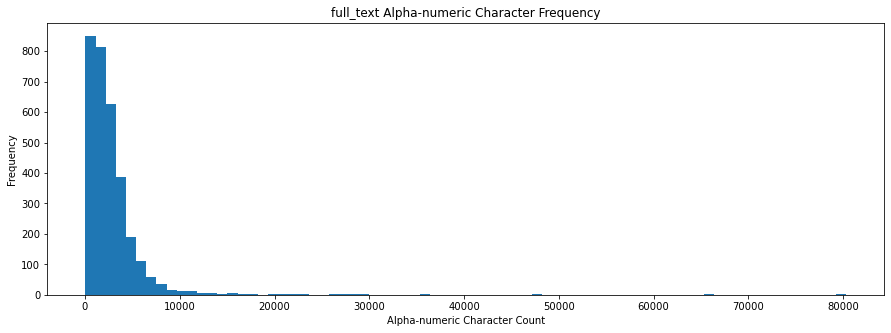

In [2]:
# counting alpha-numeric characters in full_text
import re
import matplotlib.pyplot as plt
full_text=df.full_text
full_text_count = []
for text in full_text:
    text = text.replace('\n','')
    text = re.sub(r'[^a-zA-Z0-9]','',text)
    full_text_count.append(len(text))
    
# plot frequency     
plt.rcParams['figure.figsize'] = (15, 5)
plt.hist(full_text_count,bins = 75)
plt.title('full_text Alpha-numeric Character Frequency')
plt.xlabel('Alpha-numeric Character Count')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

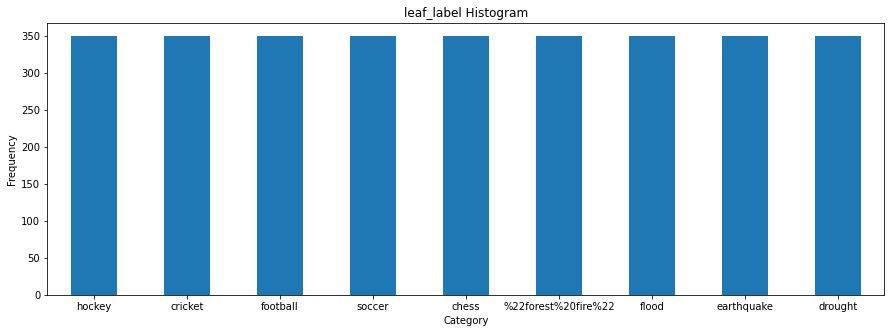

In [3]:
# histogram of leaf_label
df['leaf_label'].value_counts().plot(kind = 'bar',rot = 0)
plt.title('leaf_label Histogram')
plt.xlabel('Category')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

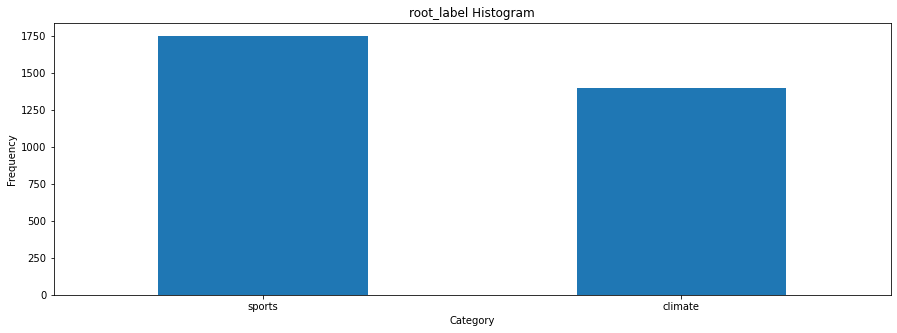

In [4]:
# histogram of root_label
df['root_label'].value_counts().plot(kind ='bar',rot = 0)
plt.title('root_label Histogram')
plt.xlabel('Category')
plt.ylabel('Frequency')

***Interpret Plots: Provide qualitative interpretations of the histograms.***

The alpha-numeric histogram right skewed with an average around 2,500 characters. Additionally, most alpha-numeric character counts lie within 0 and 10,000.

The leaf_label histogram is evenly distributed as all categories have the same frequency, which is 350.

The root_label histogram is not evenly distributed. The sports category appears more frequently than the climate category; sports appears 1750 times while climate appears 1400 times. 

## Binary Classification

In [5]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size = 0.2)
print('Train data size:', train.shape)
print('Test data size:', test.shape)

Train data size: (2520, 2)
Test data size: (630, 2)


### Question 2

***Report the number of training and testing samples***

There are 2520 training samples and 630 testing samples

In [7]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [8]:
# clean text and remove numbers and punctuation
import string
table = str.maketrans(dict.fromkeys(string.punctuation))

for i in list(train.index):
    train.full_text[i] = clean(train.full_text[i])
    train.full_text[i] = train.full_text[i].translate(table)
    train.full_text[i] = re.sub(r'\S*\d\S*','',train.full_text[i])
    train.full_text[i] = train.full_text[i].lower()

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
import nltk
from sklearn.feature_extraction.text import TfidfTransformer

wnl = WordNetLemmatizer()

# get pos of word
def get_pos(tag):
    pos_dict = {'JJ':'a', 'NN':'n', 'RB':'r', 'VB':'v'}
    if tag[1][:2] in list(pos_dict.keys()):
        return pos_dict[tag[1][:2]]
    else:
        return 'n'
    
# lemmatize text
def lemmatize_text(text):
    tokens = nltk.word_tokenize(text)
    tags = pos_tag(tokens)
    return  [wnl.lemmatize(pair[0],get_pos(pair)) for pair in tags]

# count vectorizer on corpus
tf_vectorizer = CountVectorizer(min_df = 3, stop_words='english', analyzer = lemmatize_text)
train_vectorized = tf_vectorizer.fit_transform(train.full_text)
test_vectorized = tf_vectorizer.transform(test.full_text)

# count vector to TF-IDF
transformer = TfidfTransformer()
train_tfidf = transformer.fit_transform(train_vectorized)
test_tfidf = transformer.transform(test_vectorized)

In [10]:
#train_vectorized = tf_vectorizer.fit_transform(train.full_text)
print('Train TF-IDF matrix size:', train_tfidf.shape)
#test_vectorized = tf_vectorizer.transform(test.full_text)
print('Test TF-IDF matrix size:', test_tfidf.shape)

Train TF-IDF matrix size: (2520, 14465)
Test TF-IDF matrix size: (630, 14465)


### Question 3

***What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?***

Lemmatizing considers the morphology of the word being analysed; however, it requires the words correct part of speech to accurately lemmatize it. For example, the word `dusting` requires it to be identified as a verb to correctly result in the lemma  `dust`. If it is identified as a noun (as it is the default part of speech when using the lemmatize function ), the lemma `dusting` will be returned. On the other hand, stemming only removes the end portions of a word to try to find its stem. However, it maybe inaccurately stem a word. For example, stemming the word `carries` may result in the word `car` or `carri`, which are both incorrect. 

Both lemmatization and stemming will reduce the dictionary size as only the lemma or stems of words are kept after the process is applied. For this same reason, it will also help to reduce the run time of the algorithm as less words are processed by the algorithm. If all words in a text are already in their lemma or stem form, it will not change the dictionary size. 

***min_df means minimum document frequency. How does varying min_df change the TF-IDF matrix?***

When using CountVectorizer, min_df is used to filter out words that have a frequency below min_df. Increasing this value will filter out more words and thus decrease the TF-IDF matrix columns. Decreasing the value will increase the TF-IDF matrix columns. This change in the matrix can affect the results of the analysis being done. 

 
***Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.***

Punctuations and numbers should be removed before lemmatizing as words with punctuations included are treated differently than the same word without punctuation, such as `fun!` and `fun`. Additionally, numbers are not as important when analysing the text. Removing stopwords before or after lemmatizing depends what the task requires. In cases where they may not be very useful or necessary (like sentiment analysis), they should be removed before lemmatizing. To determine whether lemmatizing should come before or after stopword removal, the intent of the task should be examined to see if they are necessary. Additionally, the task can be done with both methods to determine whether it is better the lemmatize before or after stopword removal. Additionally, the removal of these elements will reduce the run time of the algorithm analysing the text as there are less words that must be processed. 

***Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×103. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.***

The shape of the train matrix is (2520, 14465) and the shape of the test matrix is (630, 14465); for both, the number of rows match the results from section 2. 


### Question 4

***Plot the explained variance ratio across multiple different k = [1,10,50,100,200,500,1000,2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?***

Text(0, 0.5, 'Explained Variance Ratio')

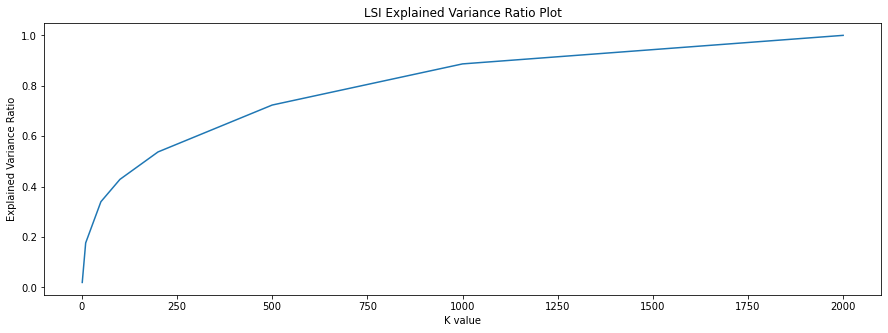

In [11]:
# Latent Semantic Indexing (LSI)

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

k = [1,10,50,100,200,500,1000,2000]
reduced_svd = [] 
explained_var = []

for i in range(len(k)):
    reduced_svd.append(TruncatedSVD(n_components=k[i], random_state=42)) # append truncated SVD
    reduced_svd[i].fit_transform(train_tfidf) # train on train tf_idf
    explained_var.append(reduced_svd[i].explained_variance_ratio_.sum()) # calculate explained variance ratio

plt.plot(k,explained_var)
plt.title('LSI Explained Variance Ratio Plot')
plt.xlabel('K value')
plt.ylabel('Explained Variance Ratio')

The concavity in the explained variance ratio plot suggests that as the K value increases, the more the amount of variance is explained. This implies that while performing dimensionality reduction, there is a trade off between the number of elements kept and the amount of variance explained. For example, if k=2, the variance explained ratio is about 0.18; this implies that the dimensionality reduce will lose a lot of data. However, is k=1000, we are able to reduce our training data by about a third while still having a variance explained ratio of about 0.89.

In [12]:
from sklearn.decomposition import NMF
from numpy import linalg

k = 50

# LSI error

# transform reduced train data back to original form
train_LSI = reduced_svd[2].inverse_transform(reduced_svd[2].transform(train_tfidf))
LSI_mse = linalg.norm(np.subtract(train_tfidf.toarray(), train_LSI), 'fro')**2
print('LSI MSE: ', LSI_mse)

# NMF error
NMFmodel = NMF(n_components=k, init='random', random_state=42, max_iter=300)
W = NMFmodel.fit_transform(train_tfidf)
H = NMFmodel.components_
train_NMF = NMFmodel.inverse_transform(W)
NMF_mse = linalg.norm(np.subtract(train_tfidf.toarray(), train_NMF), 'fro')**2
print('NMF MSE: ', NMF_mse)

LSI MSE:  1419.657741630812
NMF MSE:  1449.0553177645415


***With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the $\lVert X −WH\rVert^{2}_{F}$ in NMF or the $\lVert X −U_k\Sigma _kV^T_k\rVert^{2}_{F}$ in LSI and why?***

The residual MSE error using NMF is larger as $\lVert X −WH\rVert^{2}_{F}$=1449 and $\lVert X −U_k\Sigma _kV^T_k\rVert^{2}_{F}$=1419.7. This larger error is due to the fact that NMF is restricted to only having non-negative W and H matrices while LSI does not have any restrictions. The negative elements in the truncated SVD used in LSI allows for a less restricted approximation of X and its reduced dimensionality. 

### Question 5

Train two linear SVMs:
- Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).
- Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?
- What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

In [13]:
from sklearn import svm
from sklearn import metrics
import seaborn as sn
from sklearn.preprocessing import LabelEncoder

# transform categories into number (Climate=0, Sports=1)
Encoder = LabelEncoder()
train['binary_root_label']=Encoder.fit_transform(train['root_label'])
test['binary_root_label']=Encoder.fit_transform(test['root_label'])

train_trunc = reduced_svd[2].fit_transform(train_tfidf)
test_trunc = reduced_svd[2].transform(test_tfidf)

def train_SVM(c, train, train_label, test, test_label):
    SVM = svm.SVC(kernel='linear', C=c, random_state=42) # train svm
    SVM.fit(train, train_label)
    prob_score = SVM.decision_function(test)
    fpr, tpr, _= metrics.roc_curve(test_label,prob_score) # plot roc curve
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print("For C = ", c)
    predict=SVM.predict(test) # get svm metrics
    print('Accuracy: ', metrics.accuracy_score(test_label, predict))
    print('Recall: ', metrics.recall_score(test_label, predict))
    print('Precision: ', metrics.precision_score(test_label, predict))
    print('F-1 Score: ', metrics.f1_score(test_label, predict))
    conf_matrix = metrics.confusion_matrix(test_label, predict) # plot confusion matrix
    plt.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

For C =  1000
Accuracy:  0.9206349206349206
Recall:  0.9019073569482289
Precision:  0.9594202898550724
F-1 Score:  0.9297752808988764


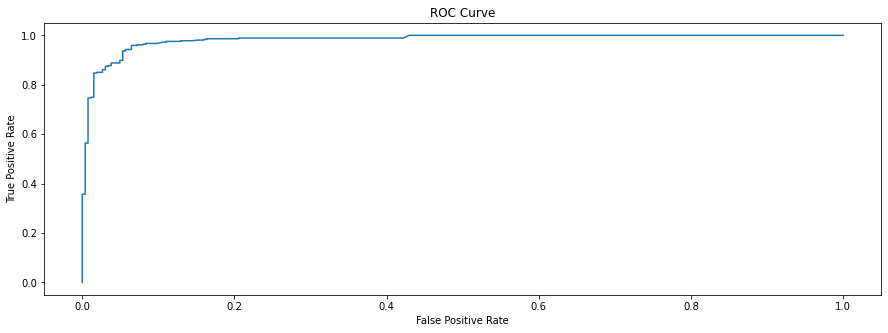

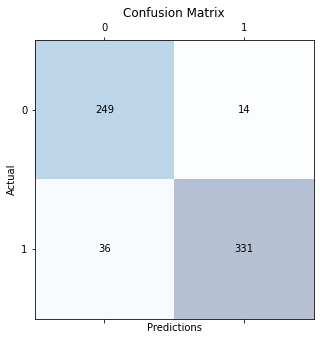

In [14]:
train_SVM(1000, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

For C =  0.0001
Accuracy:  0.5825396825396826
Recall:  1.0
Precision:  0.5825396825396826
F-1 Score:  0.7362086258776329


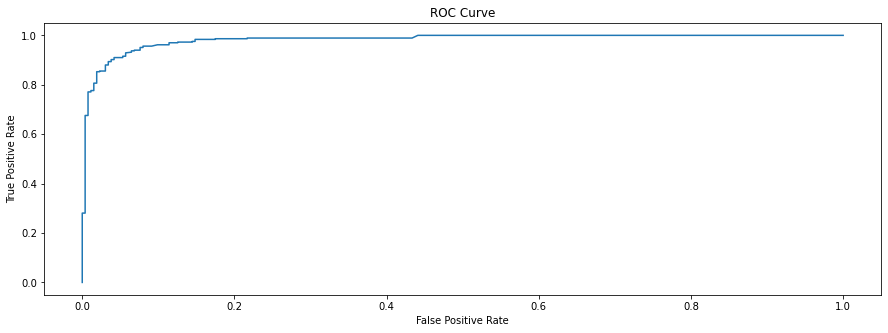

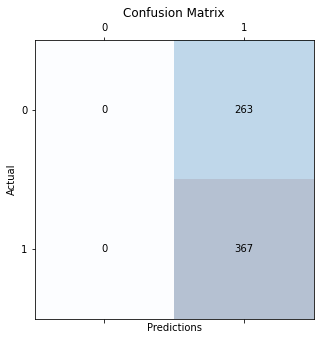

In [15]:
train_SVM(0.0001, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

For C =  100000
Accuracy:  0.9047619047619048
Recall:  0.8746594005449592
Precision:  0.9582089552238806
F-1 Score:  0.9145299145299146


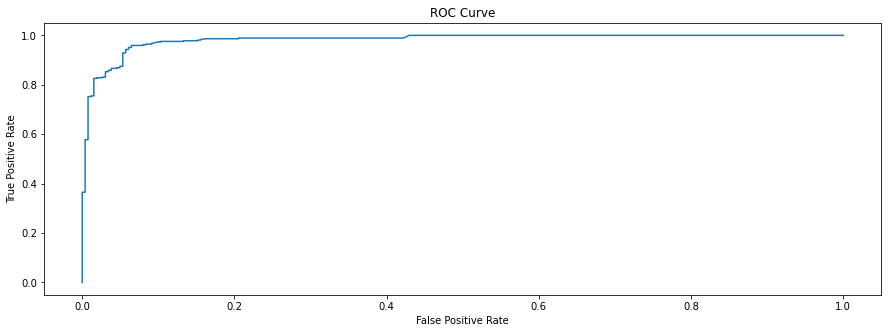

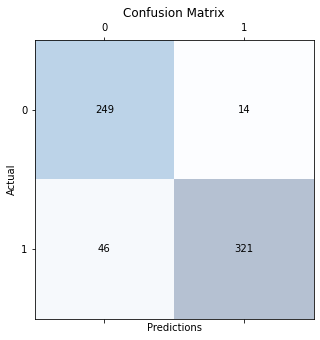

In [16]:
train_SVM(100000, train_trunc, train['binary_root_label'], test_trunc, test['binary_root_label'])

- The SVM with γ = 1000 (hard margin) performed better as it had higher metric scores (accuracy, F-1 score, precision) than the soft margin SVM. The hard margin also had slightly metric scores than the SVM with γ = 100000 with a comparable precision score.
- Gamma is a hyperparameter for the SVM that controls the error when training the SVM. However, since γ = 0.0001 is very low, the SVM is trained to have little error when separating the two classes. This causes the model to overfit the training data and leads to a low accuracy. This low accuracy can be seen by looking at the confusion matrix that shows the model predicts 0 ("Climate") when the actual value should be 1 ("sports") and vice versa. For all 630 test data points, it did not predict the label correctly.